In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader

### 导入数据

In [5]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)

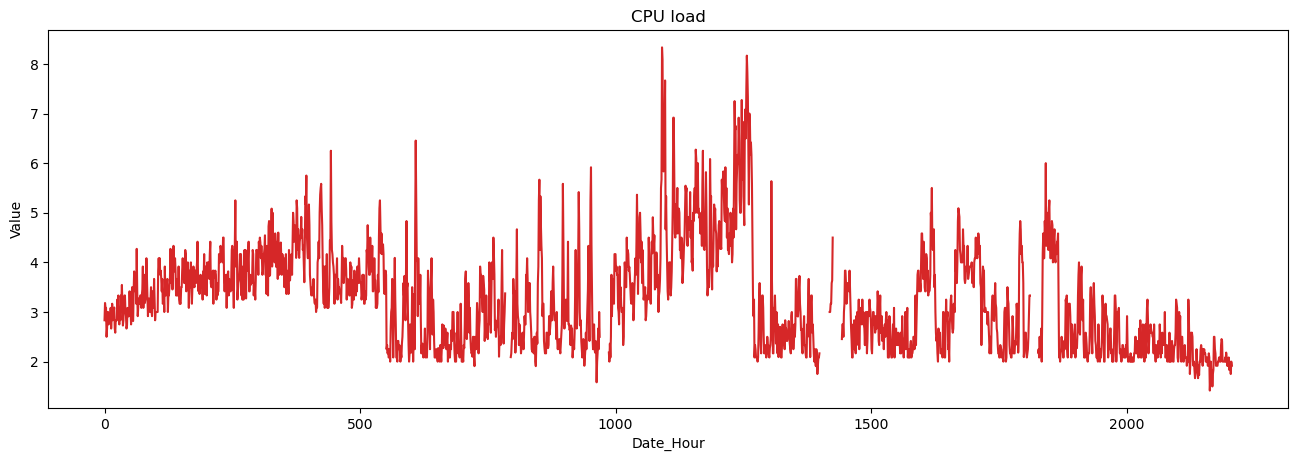

In [6]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Date_Hour', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y= df["主机CPU平均负载"], title='CPU load')

### 缺失值填充

In [5]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df["主机CPU平均负载"] = knn_mean(df["主机CPU平均负载"], 24)

### 测试集和训练集

In [6]:
train_data = df["主机CPU平均负载"][0:1704]
test_data = df["主机CPU平均负载"][1704:]
# plot_df(df, x=df.index[0:1704], y= train_data, title='CPU load')

### 归一化

In [7]:
max_value = train_data.max(axis=0, skipna=True)
min_value = train_data.min(axis=0, skipna=True)
scalar = max_value - min_value
for i in range(len(train_data)):
    train_data[i]=(train_data[i]-min_value)/scalar
# datas = list(map(lambda x: (x-min_value) / scalar, train_data[:,0]))
# plt.plot(df["日期"], train_data)
# plot_df(df, x=df.index[0:1704], y= train_data, title='CPU load')

In [8]:
for i in range(len(test_data)):
    test_data[i+1704]=(test_data[i+1704]-min_value)/scalar
# plot_df(df, x=df.index[1704:], y= test_data, title='CPU load')

In [8]:
frames = [train_data, test_data]

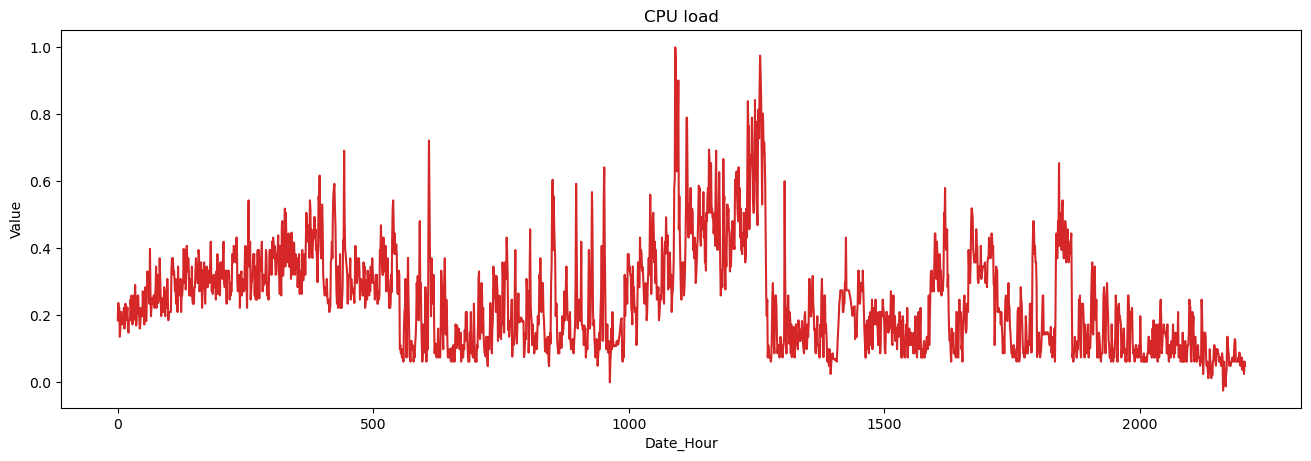

In [9]:
timeSeries = pd.concat(frames)
plot_df(df, x=df.index, y= timeSeries, title='CPU load')

In [10]:
dataframe = pd.DataFrame()
num_hour = 168
for i in range(num_hour,0,-1):
    dataframe['t-'+str(i)] = timeSeries.shift(i)

dataframe['t'] = timeSeries.values
dataframe

,t-168,t-167,t-166,t-165,t-164,t-163,t-162,t-161,t-160,t-159,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185185
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815,0.222222
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815,0.222222,0.222222
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.185185,0.236815,0.222222,0.222222,0.135807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0.111111,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,...,0.074074,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733
2203,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,...,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393
2204,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,...,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696
2205,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,0.148148,...,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696,0.061733


In [11]:
dataframe = dataframe[num_hour+1:]
dataframe

,t-168,t-167,t-166,t-165,t-164,t-163,t-162,t-161,t-160,t-159,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
169,0.236815,0.222222,0.222222,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,...,0.271615,0.296296,0.320993,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030
170,0.222222,0.222222,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,...,0.296296,0.320993,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615
171,0.222222,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,0.222222,...,0.320993,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615,0.234578
172,0.135807,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,0.222222,0.160504,...,0.358030,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615,0.234578,0.283956
173,0.160504,0.209881,0.209881,0.172844,0.197541,0.196415,0.185185,0.222222,0.160504,0.197541,...,0.320993,0.222222,0.333333,0.308652,0.283956,0.358030,0.271615,0.234578,0.283956,0.283956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0.111111,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,...,0.074074,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733
2203,0.061733,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,...,0.061733,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393
2204,0.111111,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,...,0.088667,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696
2205,0.172844,0.074074,0.160504,0.222222,0.246919,0.185185,0.086430,0.111111,0.148148,0.148148,...,0.074074,0.049393,0.061733,0.049393,0.074074,0.037037,0.061733,0.049393,0.024696,0.061733


In [12]:
# dataframe_mean= pd.DataFrame()
# for i in range(7):
#     dataframe_temp = pd.DataFrame()
#     dataframe_temp = dataframe.iloc[:,i*24:-1]
#     dataframe_mean["前"+str(7-i)+"天"] = dataframe_temp.mean(axis=1, skipna=True)
# dataframe_mean["t"] = dataframe["t"]

In [13]:
# dataframe2 = dataframe.loc[:,["t-71","t-47","t-24","t-23","t-16","t-11","t-10","t-9","t-8","t-7","t-6","t-5","t-4","t-3","t-2","t-1","t"]]
dataframe2 = dataframe.loc[:,["t-163","t-144","t-76","t-71","t-48","t-47","t-39","t-24","t-23","t-18","t-16","t-6","t-5","t-4","t-2","t-1","t"]]
# dataframe2 = dataframe2.join(dataframe_mean,how="inner")
dataframe2

,t-163,t-144,t-76,t-71,t-48,t-47,t-39,t-24,t-23,t-18,t-16,t-6,t-5,t-4,t-2,t-1,t
169,0.209881,0.246919,0.197541,0.246919,0.296296,0.296296,0.320993,0.345689,0.246919,0.283956,0.370370,0.358030,0.320993,0.222222,0.308652,0.283956,0.358030
170,0.209881,0.222222,0.271615,0.185185,0.296296,0.308652,0.296296,0.246919,0.234578,0.333333,0.331096,0.320993,0.222222,0.333333,0.283956,0.358030,0.271615
171,0.172844,0.259259,0.222222,0.209881,0.308652,0.209881,0.395067,0.234578,0.236815,0.370370,0.320993,0.222222,0.333333,0.308652,0.358030,0.271615,0.234578
172,0.197541,0.185185,0.222222,0.209881,0.209881,0.263748,0.277215,0.236815,0.234578,0.331096,0.296296,0.333333,0.308652,0.283956,0.271615,0.234578,0.283956
173,0.196415,0.172844,0.308652,0.209881,0.263748,0.259259,0.320993,0.234578,0.283956,0.320993,0.296296,0.308652,0.283956,0.358030,0.234578,0.283956,0.283956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,0.160504,0.111111,0.148148,0.049393,0.086430,0.061733,-0.024681,0.049393,0.061733,0.061733,0.129067,0.074074,0.049393,0.061733,0.074074,0.037037,0.061733
2203,0.222222,0.074074,0.135807,0.061733,0.061733,0.061733,0.012356,0.061733,0.061733,0.111111,0.123467,0.049393,0.061733,0.049393,0.037037,0.061733,0.049393
2204,0.246919,0.098770,0.148148,0.037037,0.061733,0.074074,0.061733,0.061733,0.074074,0.129067,0.061733,0.061733,0.049393,0.074074,0.061733,0.049393,0.024696
2205,0.185185,0.074074,0.135807,0.012356,0.074074,0.074074,0.024696,0.074074,0.074074,0.123467,0.061733,0.049393,0.074074,0.037037,0.049393,0.024696,0.061733


In [14]:
array = dataframe2.values
array

array([[0.20988148, 0.24691852, 0.19754074, ..., 0.30865185, 0.28395556,
        0.35802963],
       [0.20988148, 0.22222222, 0.27161481, ..., 0.28395556, 0.35802963,
        0.27161481],
       [0.17284444, 0.25925926, 0.22222222, ..., 0.35802963, 0.27161481,
        0.23457778],
       ...,
       [0.24691852, 0.09877037, 0.14814815, ..., 0.06173333, 0.04939259,
        0.0246963 ],
       [0.18518519, 0.07407407, 0.13580741, ..., 0.04939259, 0.0246963 ,
        0.06173333],
       [0.08642963, 0.12346667, 0.06173333, ..., 0.0246963 , 0.06173333,
        0.04939259]])

In [15]:
train_X = torch.Tensor(array[:1536,0:-1].reshape(-1, 1, 16))
train_Y = torch.Tensor(array[:1536,-1].reshape(-1, 1, 1))
train_X.shape

torch.Size([1536, 1, 16])

In [16]:
test_X = torch.Tensor(array[1536:1792,0:-1].reshape(-1, 1, 16))
test_Y = torch.Tensor(array[1536:1792,-1].reshape(-1, 1, 1))
test_X.shape

torch.Size([256, 1, 16])

In [17]:
train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)
train_data = DataLoader(train_data_temp, batch_size=256, shuffle=True, num_workers=1)#训练数据
test_data = DataLoader(test_data_temp, batch_size=256, shuffle=False, num_workers=2)#测试数据

### 可视化神经网络

### 建立LSTM模型

In [18]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        # x ->[1536,1,15]
        x,_ = self.layer1(x)
        # [1536,1,15] -> [1536,1,100]
        s,b,h = x.size()
        # [1536,1,100] -> [1536,100]
        x = x.view(s*b,h)
        # [1536,100] -> [1536,1]
        x = self.layer2(x)
        # [1536,1] -> [1536,1,1]
        x = x.view(s,b,-1)
        return x

model = lstm(16, 128, 1, 1)
model

lstm(
  (layer1): LSTM(16, 128)
  (layer2): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 240

In [20]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(epoch_n):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 5 == 0: # 每 2 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
    ep.append(e+1)
    losses.append(loss.item())
    if (e+1)%80 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= 0.1
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 5, Loss: 0.04209
Epoch: 10, Loss: 0.01731
Epoch: 15, Loss: 0.01584
Epoch: 20, Loss: 0.01216
Epoch: 25, Loss: 0.00962
Epoch: 30, Loss: 0.00882
Epoch: 35, Loss: 0.00842
Epoch: 40, Loss: 0.00806
Epoch: 45, Loss: 0.00762
Epoch: 50, Loss: 0.00723
Epoch: 55, Loss: 0.00686
Epoch: 60, Loss: 0.00650
Epoch: 65, Loss: 0.00616
Epoch: 70, Loss: 0.00582
Epoch: 75, Loss: 0.00552
Epoch: 80, Loss: 0.00527
Epoch: 85, Loss: 0.00522
Epoch: 90, Loss: 0.00521
Epoch: 95, Loss: 0.00520
Epoch: 100, Loss: 0.00518
Epoch: 105, Loss: 0.00516
Epoch: 110, Loss: 0.00515
Epoch: 115, Loss: 0.00514
Epoch: 120, Loss: 0.00513
Epoch: 125, Loss: 0.00512
Epoch: 130, Loss: 0.00510
Epoch: 135, Loss: 0.00509
Epoch: 140, Loss: 0.00508
Epoch: 145, Loss: 0.00507
Epoch: 150, Loss: 0.00506
Epoch: 155, Loss: 0.00505
Epoch: 160, Loss: 0.00504
Epoch: 165, Loss: 0.00504
Epoch: 170, Loss: 0.00504
Epoch: 175, Loss: 0.00504
Epoch: 180, Loss: 0.00504
Epoch: 185, Loss: 0.00503
Epoch: 190, Loss: 0.00503
Epoch: 195, Loss: 0.00503
Epoch:

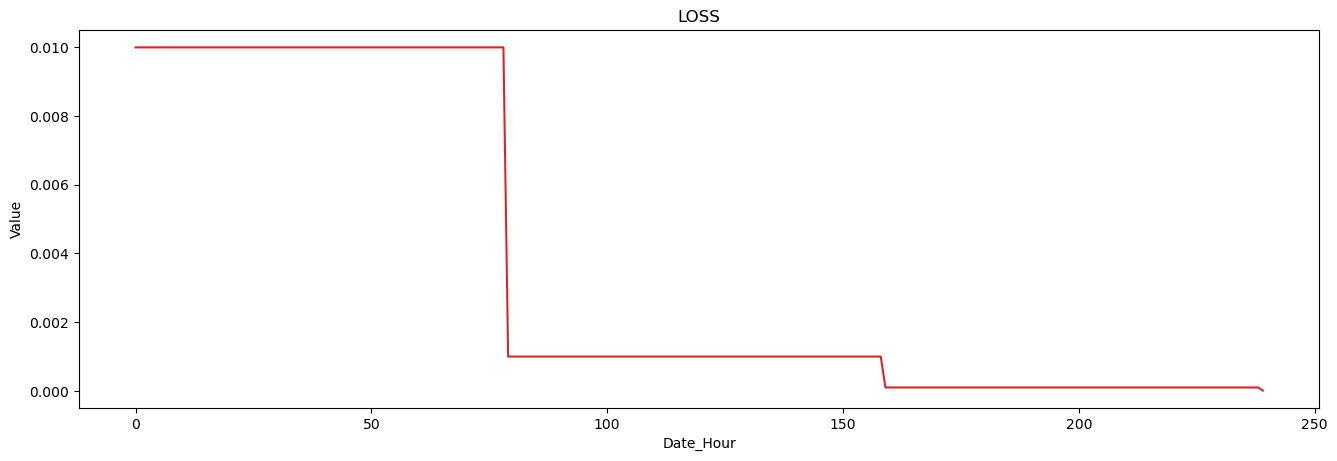

In [21]:
plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')

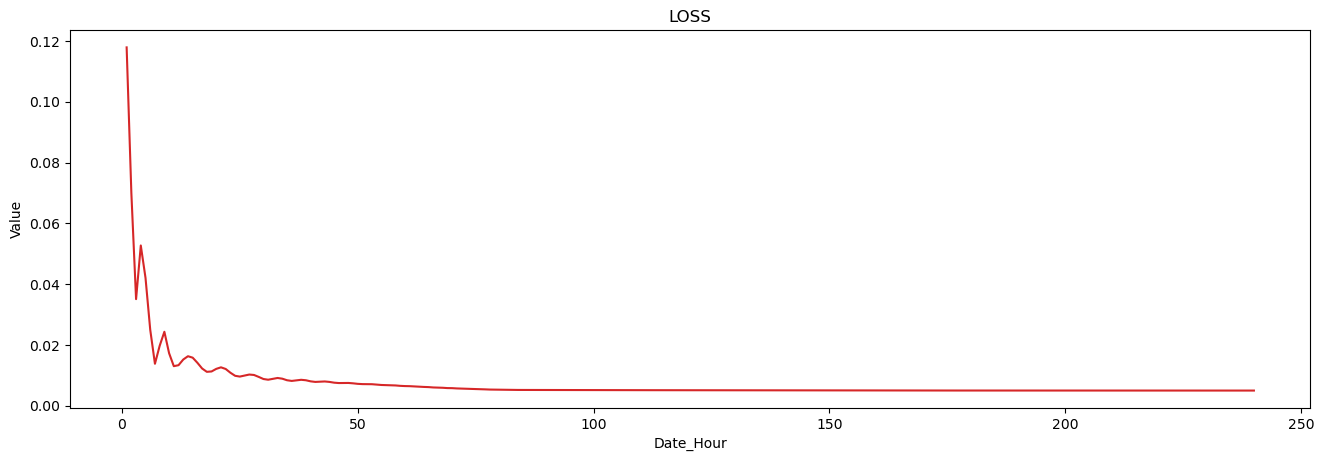

In [22]:
plot_df(df, x=ep, y= losses, title='LOSS')

In [23]:
torch.save(model, 'net.pkl')
model2 = torch.load('net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [24]:
outputs = model2(test_X)
loss = criterion(outputs, test_Y)
loss

tensor(0.0042, grad_fn=<MseLossBackward>)

In [25]:
outputs = outputs.reshape(256)
y_pred_temp = outputs.detach().numpy().tolist()
# 二维转一维
y_pred = []
for i in range(len(y_pred_temp)):
    y_pred.append(y_pred_temp[i])

In [26]:
num =256

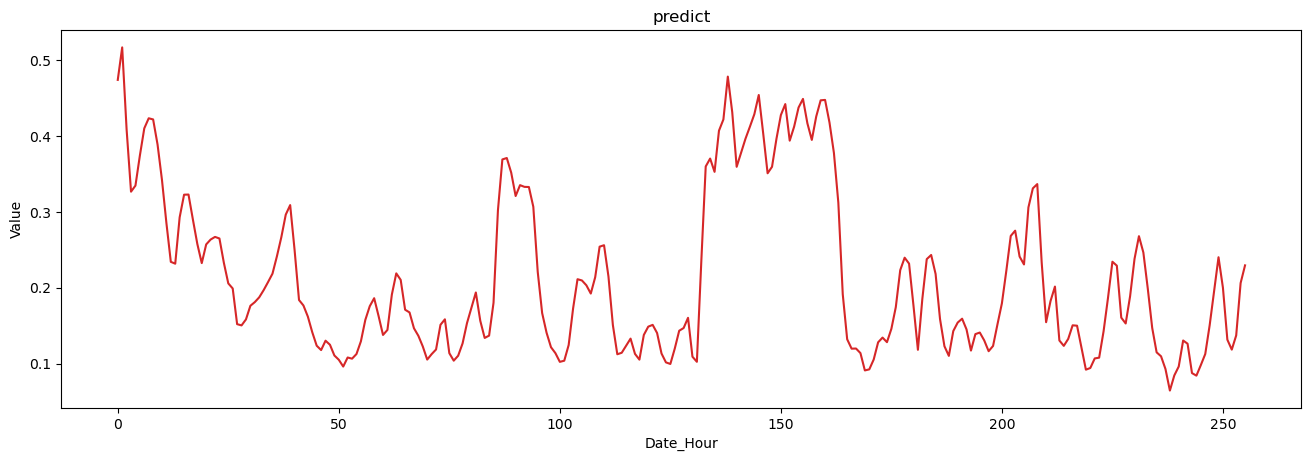

In [27]:
plot_df(df, x=range(num), y= y_pred[0:num], title='predict')

In [28]:
test_Y = test_Y.reshape(256)

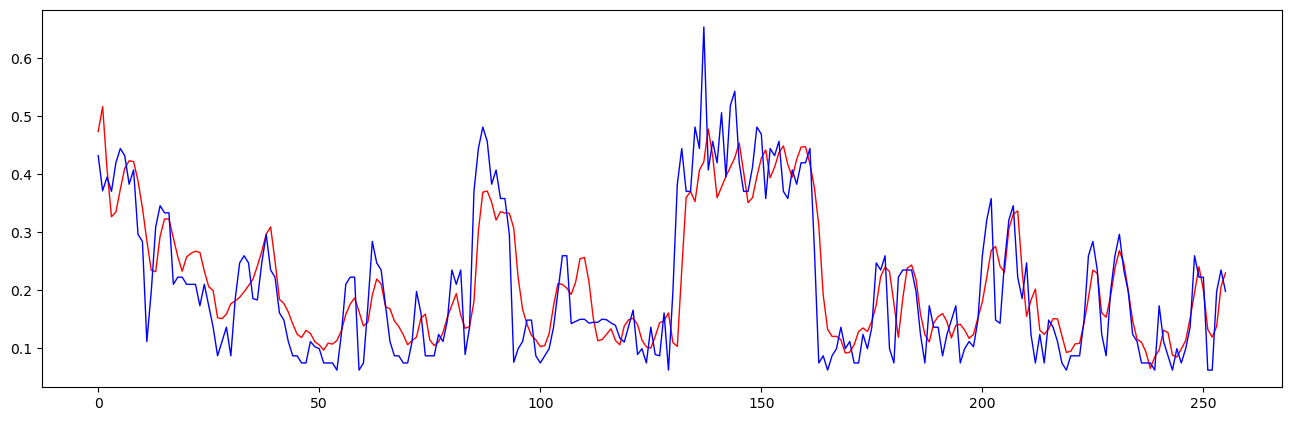

In [29]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), y_pred[0:num], c='red', lw='1')
plt.plot(range(num), test_Y[0:num], c='blue', lw='1')